In [6]:
import os, sys
from os import listdir
from os.path import isfile, isdir, join

In [7]:
import numpy as np
import pandas as pd
import cv2, imutils
from PIL import Image
import json, collections
import pickle as pkl
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import time, shutil
import argparse, pathlib

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy.spatial.transform import Rotation as R
# import pywavefronte
import pyrender, trimesh
from trimesh import Trimesh
from trimesh.visual import texture, TextureVisuals

In [4]:
SEED = 2334
np.random.seed(SEED)
plt.ion()

In [13]:
def get_timestamp(ts):
    td = timedelta(seconds=ts)
    dt = datetime.strptime("00:00:00", "%H:%M:%S") + td
    return dt.strftime("%H:%M:%S.%f")

def get_framenum(ts, fps):
    dt = datetime.strptime(ts, "%H:%M:%S.%f")
    td = dt-datetime.strptime("00:00:00.000000", "%H:%M:%S.%f")
    return int(td.total_seconds()*fps)

In [18]:
def get_texture(my_uvs, img_array):
    uvs = my_uvs
    img = Image.fromarray(img_array[..., ::-1])
    texture = pyrender.Texture(source=img, source_channels='RGB')
    material = pyrender.MetallicRoughnessMaterial(baseColorTexture=texture, doubleSided=True)
    return texture, material

x = + up - down

y = + right - left

z = doesn't matter

CSV = [x, y] times n

In [14]:
sys.argv = ['code.py', 
            '--video_path', 'F:/MASC/JALI_gaze/evaluation/360_video/R0010203_st.MP4', #'path/to/360_video.mp4',
            '--gaze_data_path', 'path/to/gaze_data.csv', #angles should be of format X, Y and in degrees
            '--save_path', 'F:/MASC/JALI_gaze/evaluation/360_video/R0010203_st_out.mp4', #'path/to/save_file.mp4'
            ]

parser = argparse.ArgumentParser()
parser.add_argument('--video_path', type=str)
parser.add_argument('--gaze_data_path', type=str)
parser.add_argument('--save_path', type=str)
parser.add_argument('--csv_seperator', type=str, default=',', required=False)
parser.add_argument('--square_resolution', type=int, default=512, required=False)
hyperparams = parser.parse_args()
print(hyperparams)

Namespace(csv_seperator=',', gaze_data_path='path/to/gaze_data.csv', save_path='F:/MASC/JALI_gaze/evaluation/360_video/R0010203_st_out.mp4', square_resolution=512, video_path='F:/MASC/JALI_gaze/evaluation/360_video/R0010203_st.MP4')


In [15]:
assert isfile(hyperparams.video_path)
video_dir = str(pathlib.Path(hyperparams.video_path).parent.absolute())
video_names = [os.path.basename(hyperparams.video_path)]
video_names.sort()
print(video_names)

save_dir = str(pathlib.Path(hyperparams.save_path).parent.absolute())
assert isdir(save_dir)
if not isdir(save_dir):
    os.mkdir(save_dir)

['R0010203_st.MP4']


(8249, 3)
(8249, 2)
(15872, 3)
(15872, 3)


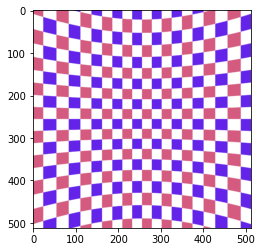

In [16]:
mesh_resolver = trimesh.resolvers.FilePathResolver('./')
mesh = trimesh.load('./VRSphereUV.obj', resolver=mesh_resolver, maintain_order=False)
texture_img = cv2.imread('./pattern_checkerboard_1_2_0-0_0_1__ffffff_805ad5_e91e63 (1).png', cv2.IMREAD_COLOR)
# wavefront_obj = pywavefront.Wavefront('./VRSphereUV.obj')
# raw_uvs = np.array(wavefront_obj.materials['Material.001'].vertices).reshape(-1, 2)
raw_uvs = mesh.visual.uv
raw_uvs[:, 0] = 1-raw_uvs[:, 0]
print(mesh.vertices.shape)
print(raw_uvs.shape)
print(mesh.faces.shape)
print(mesh.face_normals.shape)

pytexture, pymaterial = get_texture(my_uvs=raw_uvs, img_array=texture_img)
pymesh = pyrender.Mesh.from_trimesh(mesh, material=pymaterial)
offscreen_renderer = pyrender.OffscreenRenderer(viewport_width=512, 
                                                viewport_height=512,
                                                point_size=1.0)
scene = pyrender.Scene(ambient_light=[1., 1., 1.], bg_color=[255, 255, 255])
camera = pyrender.camera.PerspectiveCamera(np.deg2rad(70), znear=0.05, zfar=None, aspectRatio=1.)
pymesh_node = scene.add(pymesh)
ssc = -scene.scale

rotation = R.from_euler('xyz', [0, -90, 0], degrees=True)
rot_mat = rotation.as_matrix()
scale_mat = np.identity(3)
rot_mat = np.matmul(scale_mat, rot_mat)
cam_pose = np.identity(4)
cam_pose[:3, :3] = rot_mat
# cam_pose[:3, 3] = np.array([0, 0, 10])

camera_node = scene.add(camera, pose=cam_pose)
color, depth = offscreen_renderer.render(scene)
render = cv2.cvtColor(color,cv2.COLOR_RGB2BGR)
# cv2.imshow('RENDER', render)
# cv2.waitKey(0)
plt.imshow(render)
plt.show()

In [17]:
gaze_df = pd.read_csv(hyperparams.gaze_data_path, sep=',', header=None).to_numpy()
gaze_df = gaze_df.astype(np.float32)
print(gaze_df.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/gaze_data.csv'

In [19]:
exit_flag = False
fixed_height = hyperparams.square_resolution
camera_offsets = (0, 0, 0)


# comment out when using actual gaze
gaze_df = np.zeros((1, 2), dtype=np.float32)
gaze_df[:, 0] = 10
gaze_df[:, 1] = 30

for vid_idx in range(len(video_names)):
    vid_name = video_names[vid_idx]
    vid_prefix = vid_name.split('.')[0]
    vid_path = join(video_dir, vid_name)
    
    cap = cv2.VideoCapture(vid_path)
    width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps, frame_count = cap.get(cv2.CAP_PROP_FPS), int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(vid_prefix)
    print('RES:{}x{}|FPS:{}'.format(width, height, fps))

    writer = cv2.VideoWriter(hyperparams.save_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                             fps, (fixed_height, fixed_height))
    assert (gaze_df.ndim==2)
    if gaze_df.shape[0]>=frame_count:
        gaze_df = gaze_df[:frame_count, ...]
    else:
        gaze_df = np.pad(gaze_df, ((0, frame_count-gaze_df.shape[0]), (0, 0)), mode='edge')

    for frame_num in tqdm(range(frame_count)):
        ret, frame = cap.read()
        if not ret:
            break

        frame_copy = frame.copy()
        frame_resized = imutils.resize(frame, height=1000, inter=cv2.INTER_LANCZOS4)
        pytexture, pymaterial = get_texture(my_uvs=raw_uvs, img_array=frame_resized)
        pymesh = pyrender.Mesh.from_trimesh(mesh, material=pymaterial)

        rotation = R.from_euler('xyz', [gaze_df[frame_num, 0], -90-gaze_df[frame_num, 1], 0], degrees=True)
        rot_mat = rotation.as_matrix()
        scale_mat = np.identity(3)
        rot_mat = np.matmul(scale_mat, rot_mat)
        cam_pose = np.identity(4)
        cam_pose[:3, :3] = rot_mat

        scene.remove_node(pymesh_node)
        scene.remove_node(camera_node)
        pymesh_node = scene.add(pymesh)
        camera_node = scene.add(camera, pose=cam_pose)
        
        color, depth = offscreen_renderer.render(scene)
        render = cv2.cvtColor(color,cv2.COLOR_RGB2BGR)
        disp_frame = render.copy()
        writer.write(disp_frame)
        cv2.imshow('Video', disp_frame)
        ch = cv2.waitKey(1)
        if ch<0:
            continue
        elif chr(ch)=='x':
            exit_flag = True
            break
        elif chr(ch)=='n':
            break
    writer.release()
    if exit_flag:
        break
cv2.destroyAllWindows()

R0010203_st
RES:1920x960|FPS:29.970001496362414


  0%|          | 0/21030 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
exit_flag = False
fixed_height = hyperparams.square_resolution
camera_offsets = (0, 0, 0)
gaze_df = np.zeros((1, 2), dtype=np.float32)
gaze_df[:, 0] = 10
gaze_df[:, 1] = 30

for vid_idx in range(len(video_names)):
    vid_name = video_names[vid_idx]
    vid_prefix = vid_name.split('.')[0]
    vid_path = join(video_dir, vid_name)
    
    cap = cv2.VideoCapture(vid_path)
    width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps, frame_count = cap.get(cv2.CAP_PROP_FPS), int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(vid_prefix)
    print('RES:{}x{}|FPS:{}'.format(width, height, fps))

    writer = cv2.VideoWriter(hyperparams.save_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                             fps, (fixed_height, fixed_height))
    assert (gaze_df.ndim==2)
    if gaze_df.shape[0]>=frame_count:
        gaze_df = gaze_df[:frame_count, ...]
    else:
        gaze_df = np.pad(gaze_df, ((0, frame_count-gaze_df.shape[0]), (0, 0)), mode='edge')

    for frame_num in tqdm(range(frame_count)):
        ret, frame = cap.read()
        if not ret:
            break

        frame_copy = frame.copy()
        frame_resized = imutils.resize(frame, height=1000, inter=cv2.INTER_LANCZOS4)
        pytexture, pymaterial = get_texture(my_uvs=raw_uvs, img_array=frame_resized)
        pymesh = pyrender.Mesh.from_trimesh(mesh, material=pymaterial)

        rotation = R.from_euler('xyz', [gaze_df[frame_num, 0], -90-gaze_df[frame_num, 1], 0], degrees=True)
        rot_mat = rotation.as_matrix()
        scale_mat = np.identity(3)
        rot_mat = np.matmul(scale_mat, rot_mat)
        cam_pose = np.identity(4)
        cam_pose[:3, :3] = rot_mat

        scene.remove_node(pymesh_node)
        scene.remove_node(camera_node)
        pymesh_node = scene.add(pymesh)
        camera_node = scene.add(camera, pose=cam_pose)
        
        color, depth = offscreen_renderer.render(scene)
        render = cv2.cvtColor(color,cv2.COLOR_RGB2BGR)
        disp_frame = render.copy()
        writer.write(disp_frame)
        # cv2.imshow('Video', disp_frame)
        # ch = cv2.waitKey(1)
        if ch<0:
            continue
        elif chr(ch)=='x':
            exit_flag = True
            break
        elif chr(ch)=='n':
            break
    writer.release()
    if exit_flag:
        break
cv2.destroyAllWindows()

R0010203_st
RES:1920x960|FPS:29.970001496362414


  0%|          | 0/21030 [00:00<?, ?it/s]

In [10]:
if isfile(join(save_dir, 'temp.mp4')):
    os.remove(join(save_dir, 'temp.mp4'))
cmd = 'ffmpeg -y -i "{}" -i "{}" -map 0:v -map 1:a -c:v libx264 -c:a copy -strict -2 "{}"'.format(hyperparams.save_path, 
                                                                                             hyperparams.video_path, 
                                                                                             join(save_dir, 'temp.mp4'))
os.system(cmd)
if isfile(hyperparams.save_path):
    os.remove(hyperparams.save_path)
shutil.move(join(save_dir, 'temp.mp4'), hyperparams.save_path)

'D:/Datasets/JALI/360_renders/360 Speaking Video Cafe scene.mp4'